<a href="https://colab.research.google.com/github/yoheikikuta/US-patent-analysis/blob/master/tripletloss_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tripletloss on MNIST dataset.

A tiny modified version of https://www.kaggle.com/guichristmann/training-a-triplet-loss-model-on-mnist/data.

### Prerequisites

In [0]:
import tensorflow as tf 

import pandas as pd
import random
import numpy as np

%matplotlib inline

In [0]:
# Loading MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()

In [0]:
def reorganizeMNIST(x, y):
    assert x.shape[0] == y.shape[0]
    
    dataset = {i: [] for i in range(10)}
    
    for i in range(x.shape[0]):
        dataset[y[i]].append(x[i])
        
    return dataset

def get_batch(dataset, k):
    # Sample BATCH_K random images from each category of the MNIST dataset,
    # returning the data along with its labels
    batch = []
    labels = []
    
    for l in range(10):
        indices = random.sample(range(len(dataset[l])), k)
        indices = np.array(indices)

        batch.append([dataset[l][i] for i in indices])
        labels += [l] * k

    batch = np.array(batch).reshape(10 * k, 28, 28, 1)
    labels = np.array(labels)
    
    # Shuffling labels and batch the same way
    s = np.arange(batch.shape[0])
    np.random.shuffle(s)
    
    batch = batch[s]
    labels = labels[s]
    
    return batch, labels

train_set = reorganizeMNIST(train_images, train_labels)
valid_set = reorganizeMNIST(test_images, test_labels)

In [4]:
[len(train_set[idx]) for idx in range(10)]

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context('notebook', font_scale=1.5, rc={"lines.linewidth": 2.5})

from sklearn.manifold import TSNE

def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.show()

### t-SNE plots of raw data for each category

- Pick up N(=32) samples for each category (0, 1, ..., 9)
- Project these data onto 2-dimensional space using t-SNE
- Check the results

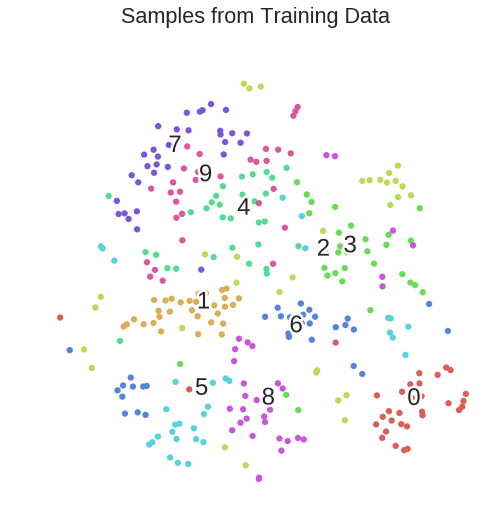

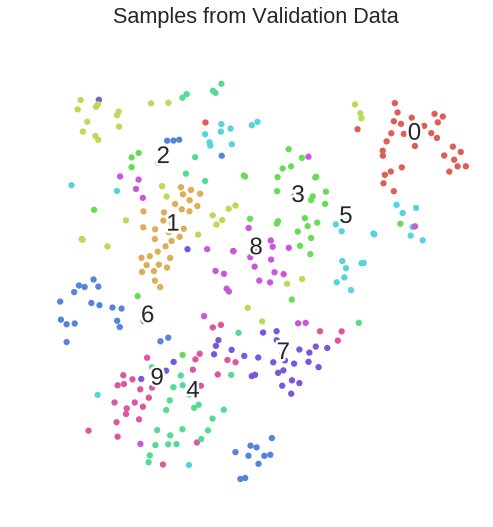

In [6]:
# Getting a batch from training and validation data for visualization
x_train, y_train = get_batch(train_set, 32)
x_val, y_val = get_batch(valid_set, 32)

x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)
    
# Generating and visualizing t-SNE embeddings of the raw data
# of the first 320 samples.
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train)
scatter(train_tsne_embeds, y_train, "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(x_val)
scatter(eval_tsne_embeds, y_val, "Samples from Validation Data")

We can see each data tends to gather according to its category.  
If we use a tripletloss model, we expect this data gather more and more.

## Define tripletloss model and check its performance

We conduct various experiments:
- Euclidean distance, selecting the hardest examples

### Euclidean distance, selecting the hardest examples

In [0]:
EPOCHS = 1000
TL_MARGIN = 0.2 # The minimum distance margin
EMBEDDING_DIM = 50 # Size of the embedding dimension (units in the last layer)

def bh_triplet_loss(dists, labels):
    # Defines the "batch hard" triplet loss function.
    
    same_identity_mask = tf.equal(tf.expand_dims(labels, axis=1),
                                  tf.expand_dims(labels, axis=0))
    negative_mask = tf.logical_not(same_identity_mask)
    positive_mask = tf.logical_xor(same_identity_mask,
                                   tf.eye(tf.shape(labels)[0], dtype=tf.bool))

    furthest_positive = tf.reduce_max(dists*tf.cast(positive_mask, tf.float32), axis=1)
    closest_negative = tf.map_fn(lambda x: tf.reduce_min(tf.boolean_mask(x[0], x[1])),
                                (dists, negative_mask), tf.float32)
    
    diff = furthest_positive - closest_negative
    
    return tf.maximum(diff + TL_MARGIN, 0.0)


### NON-CNN model: this does not lead good results
# def embedImages(Images):
#     flat = tf.layers.flatten(Images, name='flatten')
#     nonlinear_flat = tf.layers.dense(flat,
#                                  activation=tf.nn.relu,
#                                  kernel_initializer=tf.truncated_normal_initializer,
#                                  units=EMBEDDING_DIM,
#                                  name='nonlinear_flat')
#     embeddings = tf.layers.dense(nonlinear_flat,
#                                  activation=None,
#                                  kernel_initializer=tf.truncated_normal_initializer,
#                                  units=10,
#                                  name='embeddings')
    
#     return embeddings


def embedImages(Images):
    conv1 = tf.layers.conv2d(Images,
                             filters=128, kernel_size=(7, 7),
                             padding='same',
                             activation=tf.nn.relu,
                             kernel_initializer=tf.truncated_normal_initializer,
                             name='conv1')
    
    pool1 = tf.layers.max_pooling2d(conv1,
                                    pool_size=(2, 2), strides=(2, 2),
                                    padding='same',
                                    name='pool1')
        
    flat = tf.layers.flatten(pool1, name='flatten')
    
    # Linear activated embeddings
    embeddings = tf.layers.dense(flat,
                                 activation=None,
                                 kernel_initializer=tf.truncated_normal_initializer,
                                 units=EMBEDDING_DIM,
                                 name='embeddings')
    
    normalized_embeddings = tf.math.l2_normalize(embeddings, axis=1)
    
    return normalized_embeddings

In [0]:
def all_diffs(a, b):
    # Returns a tensor of all combinations of a - b
    return tf.expand_dims(a, axis=1) - tf.expand_dims(b, axis=0)

def euclidean_dist(embed1, embed2):
    # Measures the euclidean dist between all samples in embed1 and embed2
    diffs = all_diffs(embed1, embed2) # get a square matrix of all diffs
    return tf.sqrt(tf.reduce_sum(tf.square(diffs), axis=-1) + 1e-12)

In [9]:
# Placeholders for inserting data
Images = tf.placeholder(tf.float32, [None, 28, 28, 1], name='images_ph')
Labels = tf.placeholder(tf.int32, [None], name='labels_ph')

# Embeds images using the defined model
embedded_images = embedImages(Images)

# Measure distance between al embeddings
dists = euclidean_dist(embedded_images, embedded_images)

# Calculate triplet loss for the give dists
loss = tf.reduce_mean(bh_triplet_loss(dists, Labels))

global_step = tf.Variable(0, trainable=False, name='global_step')
learning_rate = tf.train.exponential_decay(0.001, global_step, EPOCHS, 0.96, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss=loss, global_step=global_step)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


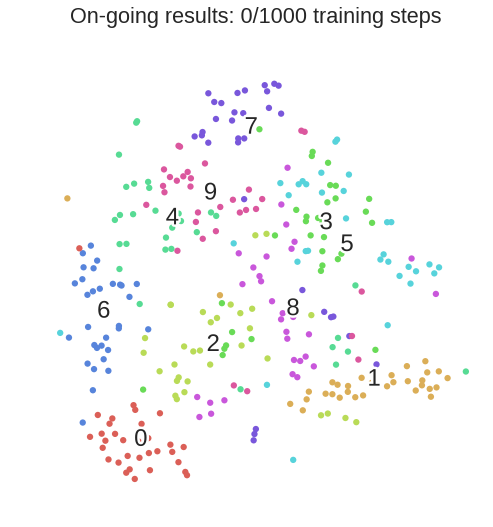

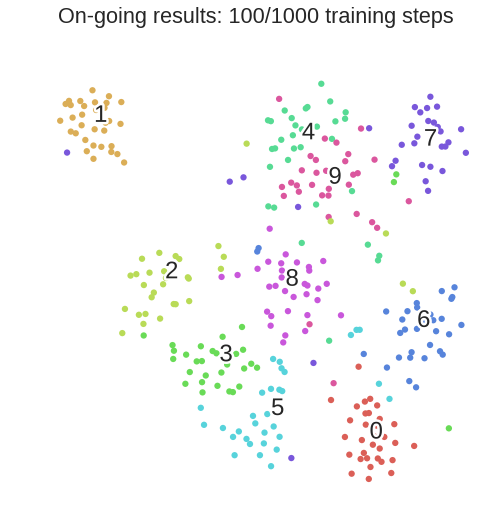

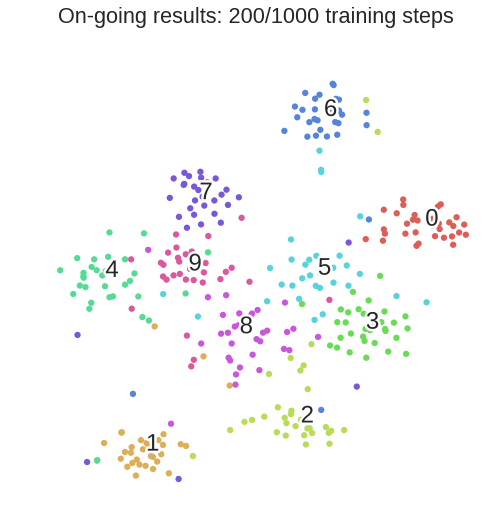

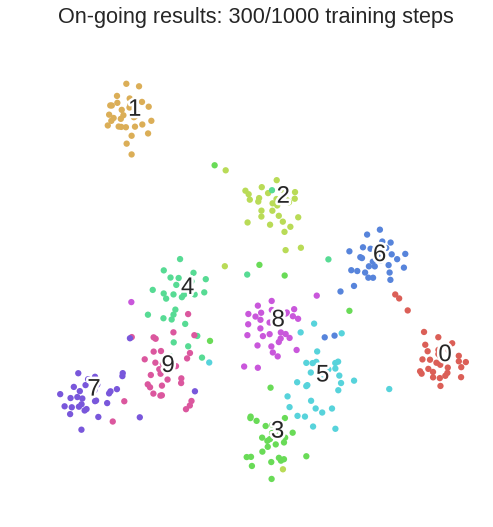

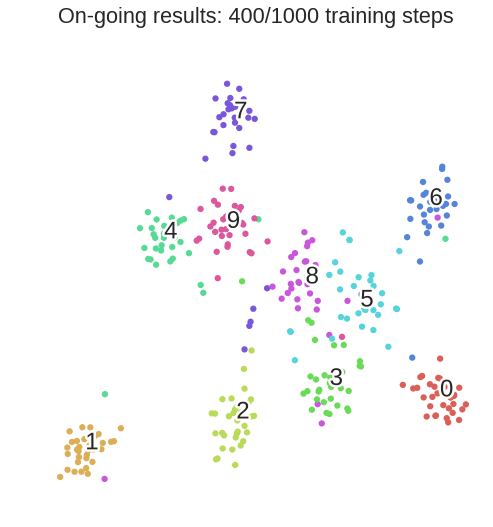

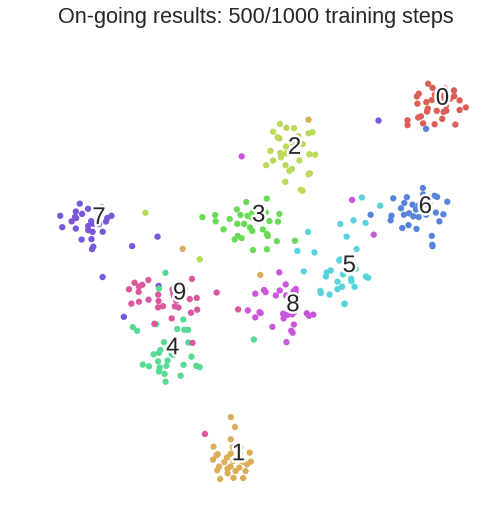

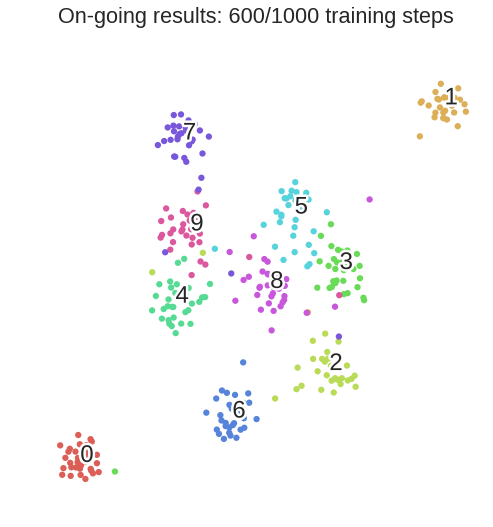

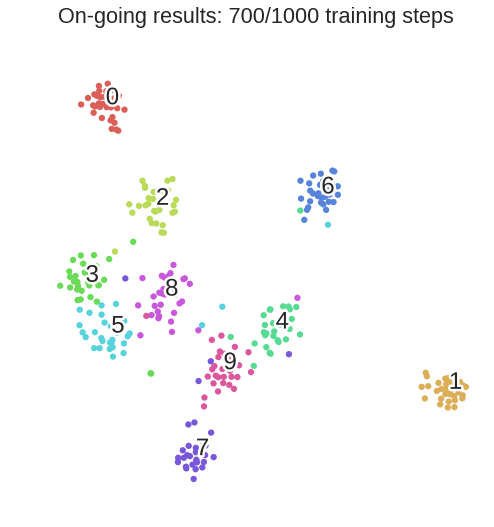

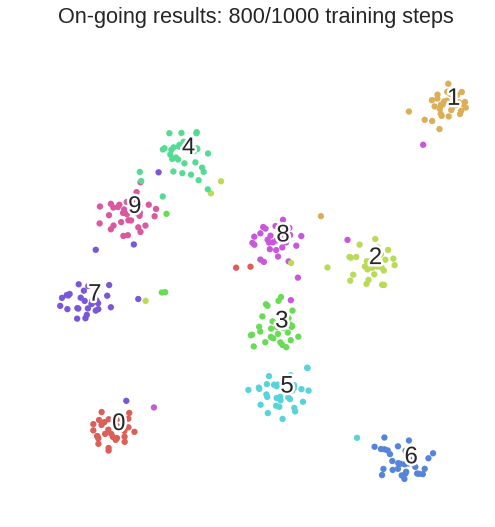

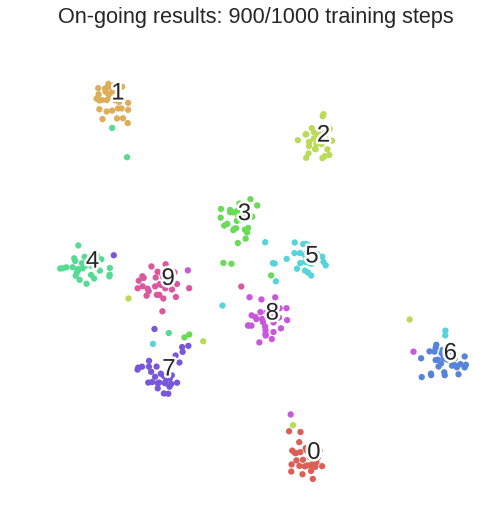

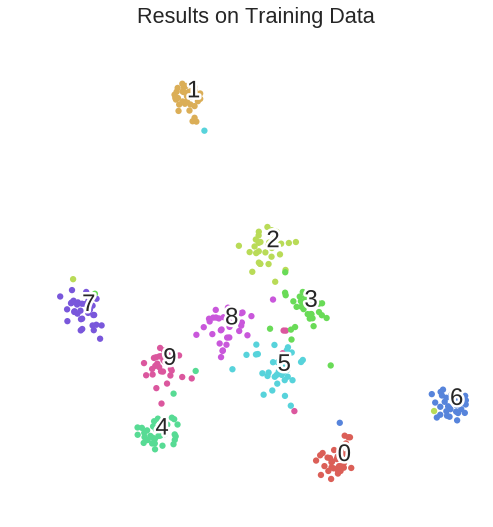

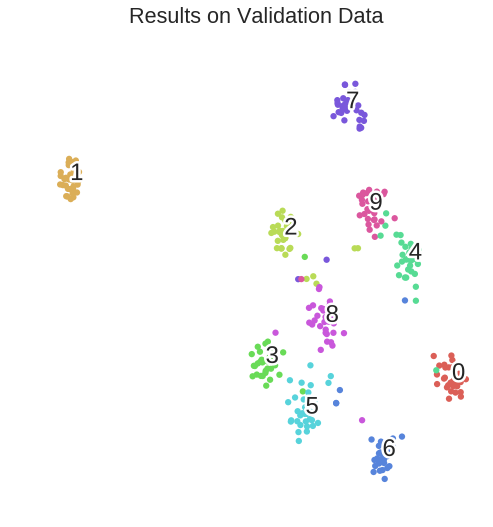

In [10]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    loss_hist = []
    lr_hist = []
    # Training
    for i in range(EPOCHS):
        data, labels = get_batch(train_set, 8)
        
        feed_dict = {Images: data, Labels: labels}
        
        _, lr, raw_loss, embeddings = sess.run([train_step,
            optimizer._lr, loss, embedded_images], feed_dict)
        
        lr_hist.append(lr)
        loss_hist.append(raw_loss)
        
        if i % 100 == 0:
          x_train, y_train = get_batch(train_set, 32)
          train_embeds = sess.run(embedded_images, 
                            feed_dict={Images: x_train, Labels:y_train})
          tsne_train = tsne.fit_transform(train_embeds)
          scatter(tsne_train, y_train, "On-going results: {}/{} training steps".format(i, EPOCHS))
          
        
    # Training is finished, get a batch from training and validation
    # data to visualize the results
    x_train, y_train = get_batch(train_set, 32)
    x_val, y_val = get_batch(valid_set, 32)
    
    # Embed the images using the network
    train_embeds = sess.run(embedded_images, 
                            feed_dict={Images: x_train, Labels:y_train})
    val_embeds = sess.run(embedded_images,
                          feed_dict={Images: x_val, Labels: y_val})
    
    tsne_train = tsne.fit_transform(train_embeds)
    tsne_val = tsne.fit_transform(val_embeds)
    
    scatter(tsne_train, y_train, "Results on Training Data")
    scatter(tsne_val, y_val, "Results on Validation Data")

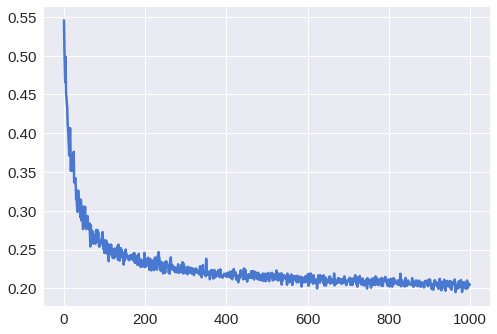

In [12]:
plt.plot(loss_hist)

In [13]:
embeddings

array([[ 0.11903258, -0.16157302,  0.15563487, ..., -0.04723447,
         0.17151535, -0.01309428],
       [ 0.12226889, -0.17214824,  0.15862979, ..., -0.05702552,
         0.16045587, -0.0166535 ],
       [ 0.12598683, -0.16579336,  0.16975953, ..., -0.02736866,
         0.16503192, -0.00647253],
       ...,
       [ 0.12593324, -0.16969821,  0.16599648, ..., -0.01684101,
         0.1470724 , -0.01753881],
       [ 0.10647993, -0.17357914,  0.16241175, ..., -0.0281824 ,
         0.14664651, -0.0106783 ],
       [ 0.12348842, -0.16430564,  0.15645654, ..., -0.04142414,
         0.15760787, -0.01427498]], dtype=float32)

### Cosine distance, selecting the hardest examples

In [0]:
# tf.reset_default_graph()